In [1]:
import csv
import scipy.stats as stats
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 
from pylab import *

In [3]:
data = np.loadtxt('170492.txt', skiprows=1)
data1 = data[:,0]
N = len(data1)
KS = {}
AD = {}
Chi2 = {}
AIC = {}
BIC = {}
para = {}

# Functions For Testing

In [870]:
def ks_test(data,distribution,args):
    stat_value , p_value = stats.kstest(data,distribution,args)
    significance = 0.05
    if(p_value < significance):
#         print("KS_test : H0 is rejected : P_value(=","%.3f" % p_value,") < α(=",significance, ")")
        return p_value ,stat_value
    else:
#         print("KS_test : H0 is accepted : P_value(=","%.3f" % p_value,") > α(=",significance, ")")
        return p_value , stat_value
    
def anderson_test(data, distribution):
    significance = 0.05
    data = sorted(data)
    if(distribution=='pearson3'):
        A_star = stats.anderson(data,distribution)
        A_star,temp1,temp2 =A_star
    else:
        A_star , C_alpha , alpha_val = stats.anderson(data,distribution)
        
    if ((A_star) >= 0.00 and (A_star) < 0.200):
            P = 1 - np.exp(-13.436 + 101.14*(A_star) - 223.73*((A_star)**2))
    if ((A_star) >= 0.200 and (A_star) < 0.340):
        P = 1 - np.exp(-8.318 + 42.796*(A_star) - 59.938*((A_star)**2))
    if ((A_star) >= 0.340 and (A_star) < 0.600):
        P = np.exp(0.9177 - 4.279*(A_star) - 1.38*((A_star)**2))
    if ((A_star) >= 0.600):
        P = np.exp(1.2937 - 5.709*(A_star) + 0.0186*((A_star)**2))    
    if(distribution =='pearson3'):
        if(P  > significance):
#             print("Anderson_test:  H0 is accepted : P(=","%.3f" % P,") > α(=",significance, ")")
            return P, A_star 
        else:
#             print("Anderson_test: H0 is rejected : P(=","%.3f" % P,") < α(=",significance, ")")
            return P, A_star
        
    else:
        if(A_star  > C_alpha[2]):
#             print("Anderson_test:  H0 is rejected : A*(=","%.3f" % A_star,") > Cα(=",C_alpha[2], ") &  P_value =","%.3f" % P  )
            return P, A_star , C_alpha[2] 
        else:
#             print("Anderson_test: H0 is accepted : A*(=","%.3f" % A_star,") < Cα(=",C_alpha[2], ") &  P_value =", "%.3f" % P )
            return P, A_star , C_alpha[2]
        
        
def chi2(dataset,dist):
    lower_val = []
    upper_val = []
    p = []
    e = []
    qc = pd.qcut(dataset,q = 20,precision=0)
    n = qc.value_counts().to_list()
    ppp = qc.categories
    for k in range(len(qc.categories)):
        lower_val.append(ppp[k].left)
        upper_val.append(ppp[k].right)
        if(dist=='norm'):
            loc,scale = stats.norm.fit(dataset)
            p.append( stats.norm.cdf(upper_val[k],loc,scale) - stats.norm.cdf(lower_val[k],loc,scale ))
        if(dist=='expon'):
            loc,scale = stats.expon.fit(dataset,floc=0)
            p.append(stats.expon.cdf(upper_val[k],loc,scale) - stats.expon.cdf(lower_val[k],loc,scale ))
        if(dist=='lognorm'):
            shape,loc,scale = stats.lognorm.fit(dataset,floc=0)
            p.append( stats.lognorm.cdf(float(upper_val[k]),shape,loc,scale) - stats.lognorm.cdf(lower_val[k],shape,loc,scale ))
        if(dist=='gamma'):
            shape,loc,scale = stats.gamma.fit(dataset,floc=0)
            p.append(stats.gamma.cdf(upper_val[k],shape,loc,scale) - stats.gamma.cdf(lower_val[k],shape,loc,scale ))
        if(dist=='gumbel_r'):
            loc,scale = stats.gumbel_r.fit(dataset)
            p.append( stats.gumbel_r.cdf(upper_val[k],loc,scale) - stats.gumbel_r.cdf(lower_val[k],loc,scale ))
        if(dist=='pearson3'):
            skew,loc,scale = stats.pearson3.fit(dataset)
            p.append(stats.pearson3.cdf(upper_val[k],skew,loc,scale) - stats.pearson3.cdf(lower_val[k],skew,loc,scale ))
        
        e.append(p[k]*N)
    stat_value , p_value = stats.chisquare(n,e,ddof = 2)
    significance = 0.05
    if(p_value < significance):
#         print("Chi2_test : H0 is rejected : P_value(=","%.3f" % p_value,") < α(=",significance, ")")
        return p_value ,stat_value
    else:
#         print("Chi2_test : H0 is accepted : P_value(=","%.3f" % p_value,") > α(=",significance, ")")
        return p_value,stat_value

# Distribution Functions

In [871]:
def norm(data1):
    mu, std = stats.norm.fit(data1)
    args = mu , std
    logLik = np.sum(stats.norm.logpdf(data1,mu,std) ) 
    xmax, xmin = np.max(data1) + 200 , np.min(data1) - 200
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    para["norm"] = args
    AD["norm"] = anderson_test(data1,'norm')
    KS["norm"] = ks_test(data1,'norm',args)
    Chi2["norm"] = chi2(data1,'norm')
    AIC["norm"] = -2*logLik + 2*len(args)
    BIC["norm"] = -2*logLik + np.log(N)*len(args)
    return p , args, mu , std
def expon(data1):
    loc , scale = stats.expon.fit(data1,floc=0)
    args = loc , scale
    mean, var, skew, kurt = stats.expon.stats(loc,scale,moments='mvsk')
    xmax, xmin = np.max(data1) + 200 , np.min(data1) - 200
    x = np.linspace(0, xmax, 100)
    p = stats.expon.pdf(x,loc,scale)
    logLik = np.sum(stats.expon.logpdf(data1,loc,scale) ) 
    para["expon"] = args
    AD["expon"] = anderson_test(data1,'expon')
    KS["expon"] = ks_test(data1,'expon',args)
    Chi2["expon"] = chi2(data1,'expon')
    AIC["expon"] = -2*logLik + 2*len(args)
    BIC["expon"] = -2*logLik + np.log(N)*len(args)
    return p, args, mean , var**0.5
def lognorm(data1):
    xmax, xmin = np.max(data1) + 200 , np.min(data1) - 200
    x = np.linspace(xmin, xmax, 100)
    args = stats.lognorm.fit(data1,floc=0)
    shape, loc, scale = args
    mean, var, skew, kurt = stats.lognorm.stats(shape,loc,scale,moments='mvsk')
    p = stats.lognorm.pdf(x,shape,loc,scale)
    logLik = np.sum(stats.lognorm.logpdf(data1,shape,loc,scale) )
    para["lognorm"] = args
    AD["lognorm"] = anderson_test(data1,'lognorm') 
    KS["lognorm"] = ks_test(data1,'lognorm',args)
    Chi2["lognorm"] = chi2(data1,'lognorm') 
    AIC["lognorm"] = -2*logLik + 2*len(args)
    BIC["lognorm"] = -2*logLik + np.log(N)*len(args)
    return p, args, mean , var**0.5
def gamma(data1):
    xmax, xmin = np.max(data1) + 200 , np.min(data1) - 200
    x = np.linspace(xmin, xmax, 100)
    args = stats.gamma.fit(data1,floc=0)
    shp, locs, scle = args
    mean, var, skew, kurt = stats.gamma.stats(shp,locs,scle,moments='mvsk')
    p = stats.gamma.pdf(x,shp,locs,scle)
    logLik = np.sum(stats.gamma.logpdf(data1,shp,locs,scle) ) 
    para["gamma"] = args
    AD["gamma"] = anderson_test((data1),'gamma')
    KS["gamma"] = ks_test(data1,'gamma',args)
    Chi2["gamma"] = chi2(data1,'gamma')
    AIC["gamma"] = -2*logLik + 2*len(args)
    BIC["gamma"] = -2*logLik + np.log(N)*len(args)
    return p, args, mean , var**0.5
def gumbel_r(data1):
    xmax, xmin = np.max(data1) + 200 , np.min(data1) - 200
    x = np.linspace(xmin, xmax, 100)
    args = stats.gumbel_r.fit(data1)
    loc, scale = args
    mean, var, skew, kurt = stats.gumbel_r.stats(loc,scale,moments='mvsk')
    p = stats.gumbel_r.pdf(x,loc,scale)
    logLik = np.sum(stats.gumbel_r.logpdf(data1,loc,scale))
    para["gumbel_r"] = args
    AD["gumbel_r"] = anderson_test(data1,'gumbel_r')
    KS["gumbel_r"] = ks_test(data1,'gumbel_r',args)
    Chi2["gumbel_r"] = chi2(data1,'gumbel_r')
    AIC["gumbel_r"] = -2*logLik + 2*len(args)
    BIC["gumbel_r"] = -2*logLik + np.log(N)*len(args)
    return p, args, mean , var**0.5
def pearson3(data1):
    xmax, xmin = np.max(data1) + 200 , np.min(data1) - 200
    x = np.linspace(xmin, xmax, 100)
    args = stats.pearson3.fit(data1)
    skew ,loc, scale = args
    mean, var, skew, kurt = stats.pearson3.stats(skew,loc,scale,moments='mvsk')
    p = stats.pearson3.pdf(x,skew,loc,scale)
    logLik = np.sum(stats.pearson3.logpdf(data1,skew,loc,scale) ) 
    para["pearson3"] = args
    AD["pearson3"] = anderson_test(data1,'pearson3')
    KS["pearson3"] = ks_test(data1,'pearson3',args)
    Chi2["pearson3"] = chi2(data1,'pearson3')
    AIC["pearson3"] = -2*logLik + 2*len(args)
    BIC["pearson3"] = -2*logLik + np.log(N)*len(args)
    return p, args , mean , var**0.5

In [872]:
def Plot():
    plt.figure(figsize=(20,12))
    plt.subplot(2,3,1)
    plt.hist(data1, bins=25, density=True, alpha=0.6, color='g')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    plt.plot(x, norm(data1)[0], 'k', linewidth=2)
    title = "Normal: mu = %.2f,  std = %.2f" % (norm(data1)[2],norm(data1)[3])
    plt.title(title)

    plt.subplot(2,3,2)
    plt.hist(data1, bins=25, density=True, alpha=0.6, color='g')
    plt.plot(x, expon(data1)[0], 'k', linewidth=2)
    title = "Exponential: mu = %.2f,  std = %.2f" % (expon(data1)[2],expon(data1)[3])
    plt.title(title)

    plt.subplot(2,3,3)
    plt.hist(data1, bins=25, density=True, alpha=0.6, color='g')
    plt.plot(x, lognorm(data1)[0], 'k', linewidth=2) 
    title = "Lognormal: mu = %.2f,  std = %.2f" % (lognorm(data1)[2],lognorm(data1)[3])
    plt.title(title)

    plt.subplot(2,3,4)
    plt.hist(data1, bins=25, density=True, alpha=0.6, color='g')
    plt.plot(x, gamma(data1)[0], 'k', linewidth=2) 
    title = "Gamma: mu = %.2f,  std = %.2f" % (gamma(data1)[2],gamma(data1)[3])
    plt.title(title)

    plt.subplot(2,3,5)
    plt.hist(data1, bins=25, density=True, alpha=0.6, color='g')
    plt.plot(x, gumbel_r(data1)[0], 'k', linewidth=2) 
    title = "Gumbel: mu = %.2f,  std = %.2f" % (gumbel_r(data1)[2],gumbel_r(data1)[3])
    plt.title(title)

    plt.subplot(2,3,6)
    plt.hist(data1, bins=25, density=True, alpha=0.6, color='g')
    xmin,xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    plt.plot(x, pearson3(data1)[0], 'k', linewidth=2) 
    title = "Pearson3: mu = %.2f,  std = %.2f" % (pearson3(data1)[2],pearson3(data1)[3])
    plt.title(title)
    plt.show()

### Finding design discharge for return period

In [873]:
def cdf2x(data1,dist):
    data2 =  sorted(data1)
    
    if(dist=='norm'):
        mu, std = stats.norm.fit(data1)
        temp = stats.norm.cdf(data2, mu, std)
    if(dist=='expon'):
        mu , std = stats.expon.fit(data1,floc=0)
        temp = stats.expon.cdf(data2, mu, std)
    if(dist=='lognorm'):
        args = stats.lognorm.fit(data1,floc=0)
        shape, loc, scale = args
        temp = stats.lognorm.cdf(data2,shape, loc, scale)
    if(dist=='gamma'):
        args = stats.gamma.fit(data1,floc=0)
        shp, locs, scle = args
        temp = stats.gamma.cdf(data2,shp, locs, scle)
    if(dist=='gumbel_r'):
        args = stats.gumbel_r.fit(data1)
        loc, scale = args
        temp = stats.gumbel_r.cdf(data2, loc, scale)
    if(dist=='pearson3'):
        args = stats.pearson3.fit(data1)
        skew ,loc, scale = args
        temp = stats.pearson3.cdf(data2, skew ,loc, scale)
    cnt = 0
    for i in temp:
        cnt = cnt+1
        if(i>49/50):
            break
    cnt = cnt-1
    temp_cdf = data2[cnt] - (data2[cnt]-data2[cnt-1])*(temp[cnt]-0.98)/(temp[cnt]-temp[cnt-1])
    return temp_cdf

# Print Functions

In [874]:
def Print(dist,distribution):
    print("Distribution :",'\x1b[1;31m'+distribution+'\x1b[0m')
    print("Mean = ","%.4f" % dist(data1)[2])
    print("Standard Deviation = ", "%.4f" %dist(data1)[3])
    print("Parameters = ", [float("{0:.4f}".format(n)) for n in dist(data1)[1]])
    if(dist == pearson3):
        print("Anderson Test:","Accept" if AD[distribution][0]>0.05 else "Reject", "\n    statistical Value (A2*) = ","%.4f" %AD[distribution][1],"\n    p Value = ","%.4f" %AD[distribution][0])
    else:
        print("Anderson Test:","Accept" if AD[distribution][2]>AD[distribution][1] else "Reject", "\n    statistical Value (A2*) = ","%.4f" %AD[distribution][1],"\n    Critical Value (α) = ","%.4f" %AD[distribution][2],"\n    p Value = ","%.4f" %AD[distribution][0])
    print("KS Test:","Accept" if KS[distribution][0]>0.05 else "Reject", "\n    P value = ","%.4f" %KS[distribution][0],"\n    Stat value = ","%.4f" %KS[distribution][1])
    print("Chi_square Test:","Accept" if Chi2[distribution][0]>0.05 else "Reject", " \n    P value = ","%.4f" %Chi2[distribution][0]," \n    Stat value = ","%.4f" %Chi2[distribution][1])
    print("AIC = ","%.4f" %AIC[distribution])
    print("BIC = ","%.4f" %BIC[distribution])
    print("\n\n")
    
def Best_print():
    print("Best fitted Distribution: ")
    print( "According to AD test:",AD_accept[0][0])
    print( "According to KS test:",KS_accept[0][0])
    print( "According to Chi2 test:",Chi2_accept[0][0])
    print( "According to AIC Value:",AIC[0][0])
    print( "According to BIC Value:",BIC[0][0])



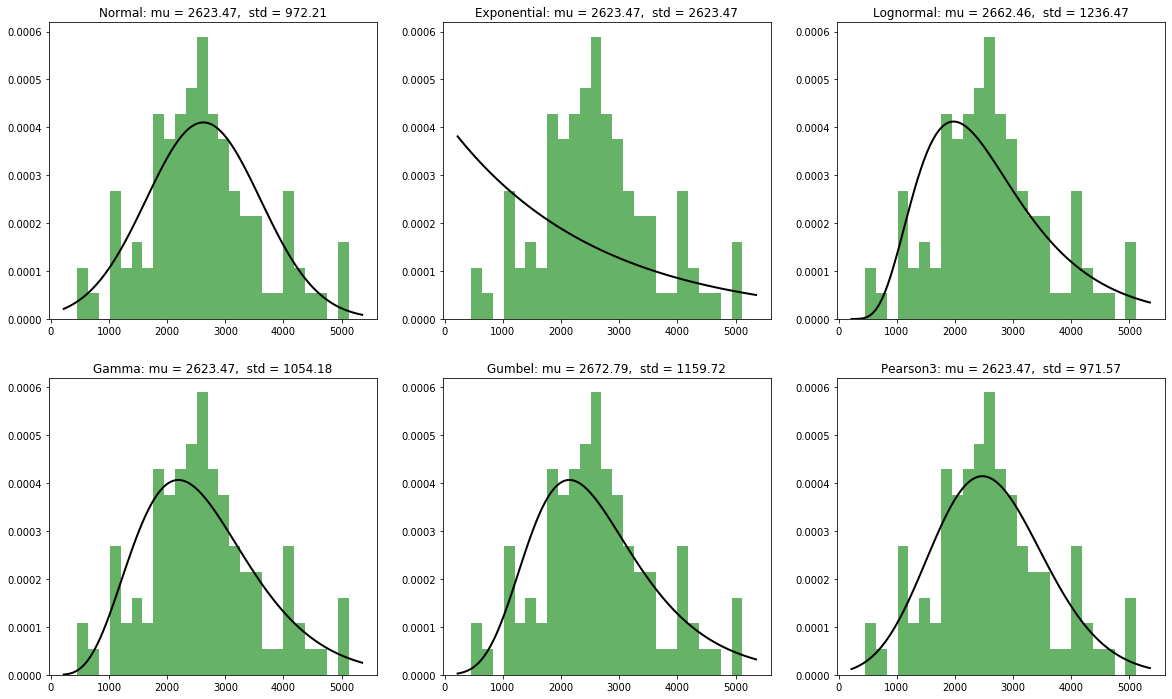

Distribution : norm
Mean =  2623.4709
Standard Deviation =  972.2060
Parameters =  [2623.4709, 972.206]
Anderson Test: Accept 
    statistical Value (A2*) =  0.5532 
    Critical Value (α) =  0.7590 
    p Value =  0.1539
KS Test: Accept 
    P value =  0.7638 
    Stat value =  0.0678
Chi_square Test: Accept  
    P value =  0.5285  
    Stat value =  15.9341
AIC =  1663.7012
BIC =  1668.9116



Distribution : expon
Mean =  2623.4709
Standard Deviation =  2623.4709
Parameters =  [0.0, 2623.4709]
Anderson Test: Reject 
    statistical Value (A2*) =  18.3595 
    Critical Value (α) =  1.3330 
    p Value =  0.0000
KS Test: Reject 
    P value =  0.0000 
    Stat value =  0.3514
Chi_square Test: Reject  
    P value =  0.0000  
    Stat value =  126.9073
AIC =  1778.4507
BIC =  1783.6610



Distribution : lognorm
Mean =  2662.4573
Standard Deviation =  1236.4680
Parameters =  [0.4419, 0.0, 2414.7593]
Anderson Test: Reject 
    statistical Value (A2*) =  1.8496 
    Critical Value (α) =  

In [875]:
Plot()
Print(norm,'norm')
Print(expon,'expon')
Print(lognorm,'lognorm')
Print(gamma,'gamma')
Print(gumbel_r,'gumbel_r')
Print(pearson3,'pearson3')
AD_accept = dict((k, v) for k, v in AD.items() if (v[0] >= 0.05))
AD_accept = sorted(AD_accept.items(),reverse=True,  key=lambda x: x[1][0])

KS_accept = dict((k, v) for k, v in KS.items() if v[0] >= 0.05)
KS_accept = sorted(KS_accept.items(),reverse=True,  key=lambda x: x[1][0])
KS_best = dict((k, v) for k, v in KS.items() if v==max(KS.values()))

Chi2_accept = dict((k, v) for k, v in Chi2.items() if v[0] >= 0.05)
Chi2_accept = sorted(Chi2_accept.items(),reverse=True,  key=lambda x: x[1][0])
Chi2_best = dict((k, v) for k, v in Chi2.items() if v==max(Chi2.values()))
AIC = sorted(AIC.items(),reverse=False,  key=lambda x: x[1])
BIC = sorted(BIC.items(),reverse=False,  key=lambda x: x[1])
Best_print()
print("\n\nDesigned Discharge for 50 year return period =","%.4f" %cdf2x(data1,AIC[0][0]))